In [1]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 31.0 MB/s eta 0:00:00


In [2]:
import torch, model, importlib
importlib.reload(model);

In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


# Data loading and preparation

In [4]:
import datasets

dataset = datasets.load_dataset('silicone', 'swda')
dataset

Generating train split:   0%|          | 0/190709 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21203 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2714 [00:00<?, ? examples/s]

Dataset silicone downloaded and prepared to /root/.cache/huggingface/datasets/silicone/swda/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Utterance', 'Dialogue_Act', 'From_Caller', 'To_Caller', 'Topic', 'Dialogue_ID', 'Conv_ID', 'Label', 'Idx'],
        num_rows: 190709
    })
    validation: Dataset({
        features: ['Utterance', 'Dialogue_Act', 'From_Caller', 'To_Caller', 'Topic', 'Dialogue_ID', 'Conv_ID', 'Label', 'Idx'],
        num_rows: 21203
    })
    test: Dataset({
        features: ['Utterance', 'Dialogue_Act', 'From_Caller', 'To_Caller', 'Topic', 'Dialogue_ID', 'Conv_ID', 'Label', 'Idx'],
        num_rows: 2714
    })
})

In [5]:
from torchtext.vocab import GloVe, vocab

pretrained_vectors = GloVe(name="6B", dim=50)
pretrained_vocab = vocab(pretrained_vectors.stoi)
pretrained_vocab.insert_token("<unk>", 0)
pretrained_vocab.insert_token("<pad>", 1)
pretrained_vocab.set_default_index(0)
pretrained_embeddings = pretrained_vectors.vectors.to(device)
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
vocab_stoi = pretrained_vocab.get_stoi()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.


.vector_cache/glove.6B.zip:   8%|▊         | 66.8M/862M [00:12<02:29, 5.32MB/s]


.vector_cache/glove.6B.zip:   8%|▊         | 67.4M/862M [00:12<02:29, 5.31MB/s]


.vector_cache/glove.6B.zip:   8%|▊         | 67.9M/862M [00:12<02:26, 5.42MB/s]


.vector_cache/glove.6B.zip:   8%|▊         | 68.5M/862M [00:12<02:27, 5.39MB/s]


.vector_cache/glove.6B.zip:   8%|▊         | 69.0M/862M [00:12<02:32, 5.21MB/s]


.vector_cache/glove.6B.zip:   8%|▊         | 69.6M/862M [00:12<02:31, 5.24MB/s]


.vector_cache/glove.6B.zip:   8%|▊         | 70.1M/862M [00:12<02:29, 5.28MB/s]


.vector_cache/glove.6B.zip:   8%|▊         | 70.7M/862M [00:12<02:30, 5.26MB/s]


.vector_cache/glove.6B.zip:   8%|▊         | 71.3M/862M [00:12<02:29, 5.28MB/s]


.vector_cache/glove.6B.zip:   8%|▊         | 71.7M/862M [00:13<03:45, 3.50MB/s]


.vector_cache/glove.6B.zip:   8%|▊         | 73.2M/862M [00:13<02:14, 5.88MB/s]


.vector_cache/glov

In [6]:
import numpy as np
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

dataset_name = 'swda'

if dataset_name == 'daily_dialog':
    max_len = max([
        len(tokenizer(sentence))
        for dialog in dataset['train']['dialog'] + dataset['validation']['dialog'] + dataset['test']['dialog']
        for sentence in dialog 
    ])
elif dataset_name == 'swda':
    max_len = max([
        len(tokenizer(sentence))
        for sentence in dataset['train']['Utterance'] + dataset['validation']['Utterance'] + dataset['test']['Utterance']
    ])
else:
    raise ValueError()

max_len

102

In [7]:
@np.vectorize
def numericalize(word, vocab_stoi):
    return vocab_stoi[word] if word in vocab_stoi else 0

def preprocess(sentence, max_len):
    # Tokenizer, word to indices, padding
    sentence = tokenizer(sentence.lower())
    sentence = sentence + ["<pad>" for _ in range(max_len-len(sentence))]
    sentence = numericalize(sentence, vocab_stoi)
    return sentence

In [8]:
# For each dialog, we take the first 5 utterances
new_dataset = dict()

if dataset_name == 'daily_dialog':
    for split in ['train', 'validation', 'test']:
        new_dataset[split] = [
            (
                np.array([preprocess(sentence, max_len=max_len) for sentence in dialog[:5]]),
                np.array([a for a in act[:5]])
            )
            for dialog, act in zip(dataset[split]['dialog'], dataset[split]['act'])
            if len(dialog) >= 5
        ]
elif dataset_name == 'swda':
    for split in ['train', 'validation', 'test']:
        out = list()
        # We split each dialogue in subdialogues of length 5
        nb_dialogues = np.max(np.array(dataset[split]['Dialogue_ID']).astype(int)) + 1
        current_subdialog = list()
        current_subdialog_id = 0
        in_current_subdialog = 0
        # We will only consider 1/4 of the training set
        for line in dataset[split]:
            if in_current_subdialog == 5:
                current_subdialog_id += 1
                in_current_subdialog = 0
                out += current_subdialog
                current_subdialog = list()
            
            current_subdialog.append(
                dict(
                    Utterance = preprocess(line['Utterance'], max_len=max_len),
                    Dialogue_ID = current_subdialog_id,
                    Idx = in_current_subdialog,
                    Label = line['Label']
                )
            )
            in_current_subdialog += 1
        
        if in_current_subdialog == 5:
            out += current_subdialog
        
        new_dataset[split] = out
else:
    raise ValueError()
del dataset

In [9]:
class DialogActDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return dict(
            dialog = torch.tensor(self.data[idx][0]),
            act = torch.tensor(self.data[idx][1])
        )

class SwDADataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data) // 5

    def __getitem__(self, idx):
        subdialog = [elt for elt in self.data if elt['Dialogue_ID']==idx]
        subdialog = sorted(subdialog, key=lambda ut: ut['Idx'])
        return dict(
            dialog = torch.tensor(
                torch.stack(
                    [
                        torch.tensor(ut['Utterance']) for ut in subdialog
                    ],
                    dim = 0
                )
            ),
            act = torch.tensor([ut['Label'] for ut in subdialog])
        )

In [39]:
kwargs = dict(
    batch_size = 512,
    shuffle = True,
    drop_last = True,
    generator = torch.Generator(device=device)
)

train_loader = torch.utils.data.DataLoader(
    SwDADataset(new_dataset['train']), **kwargs
)
val_loader = torch.utils.data.DataLoader(
    SwDADataset(new_dataset['validation']), **kwargs
)
test_loader = torch.utils.data.DataLoader(
    SwDADataset(new_dataset['test']), **kwargs
)

In [40]:
def evaluate(model, test_loader, device):
    """Measures the accuracy of `model` on `test_loader`."""
    model.eval()
    with torch.no_grad():
        correct = 0
        for batch in test_loader:
            x = batch['dialog'].to(device)
            target = batch['act'].to(device)
            out = model(x)
            out_argmax = torch.argmax(out, dim=-1)
            correct += torch.sum( torch.where( out_argmax == target, 1, 0 ) ).item()
            
    return correct / len(test_loader) / kwargs['batch_size'] / 5

# Vanilla Attention
## Training

In [41]:
import torchinfo

network = model.Seq2SeqModel(
    pretrained_embeddings = pretrained_embeddings,
    encoder = model.HierarchicalEncoder(
        input_size = pretrained_embeddings.shape[1],
        sequence_length = 5,
        hidden_size = 128,
        persona_level = False,
    ),
    decoder = model.VanillaAttentionDecoder(
        hidden_size = 128,
        sequence_length = 5,
    ),
    nb_classes = 46,
    hidden_size = 128,
)
torchinfo.summary(network)

Layer (type:depth-idx)                   Param #
Seq2SeqModel                             --
├─Embedding: 1-1                         (20,000,050)
├─HierarchicalEncoder: 1-2               --
│    └─GRU: 2-1                          138,240
│    └─GRU: 2-2                          296,448
├─VanillaAttentionDecoder: 1-3           --
│    └─Linear: 2-3                       513
│    └─GRUCell: 2-4                      394,752
├─Linear: 1-4                            11,822
Total params: 20,841,825
Trainable params: 841,775
Non-trainable params: 20,000,050

In [42]:
# To ensure the model is actually learning something, we compute the accuracy before any training:
print(evaluate(network, test_loader, device))

0.001171875


In [ ]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

def train(network, train_loader, val_loader, optimizer, loss_fn, device, n_epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []
    print('Start of training…')
    for epoch in range(n_epochs):
        # Training
        network.train()
        train_loss = 0

        for batch in tqdm(train_loader):

            optimizer.zero_grad()
            
            x = batch['dialog'].to(device)
            target = batch['act'].to(device)

            out = network(x).transpose(1,2)
            loss = loss_fn(out, target.long())

            train_loss += loss.item()
            loss.backward()
            optimizer.step()

            
        if (epoch+1)%5 == 0: print(f'Epoch {epoch+1}/{n_epochs}, training loss: {train_loss/len(train_loader)/kwargs["batch_size"]:.4g}')
        train_losses.append(train_loss/len(train_loader)/kwargs['batch_size'])

        # Testing
        network.eval()
        with torch.no_grad():
            loss = 0
            for batch in val_loader:
                x = batch['dialog'].to(device)
                target = batch['act'].to(device)
                out = network(x).transpose(1,2)
                loss += loss_fn(out, target.long()).item()
                
        if (epoch+1)%5 == 0: print(f'Epoch {epoch+1}/{n_epochs}, val loss: {loss/len(val_loader)/kwargs["batch_size"]:.4g}')
        val_losses.append(loss/len(val_loader)/kwargs['batch_size'])

        acc = evaluate(network, val_loader, device)
        if (epoch+1)%5 == 0: print(f'Epoch {epoch+1}/{n_epochs}, val accuracy: {acc:.4g}')
        val_accuracies.append(acc)
    
    return train_losses, val_losses, val_accuracies

train_losses, val_losses, val_accuracies = train(
    network,
    train_loader,
    test_loader,
    optimizer = torch.optim.SGD(network.parameters(), lr=0.01),
    loss_fn = torch.nn.CrossEntropyLoss(),
    device = device,
    n_epochs = 10
)

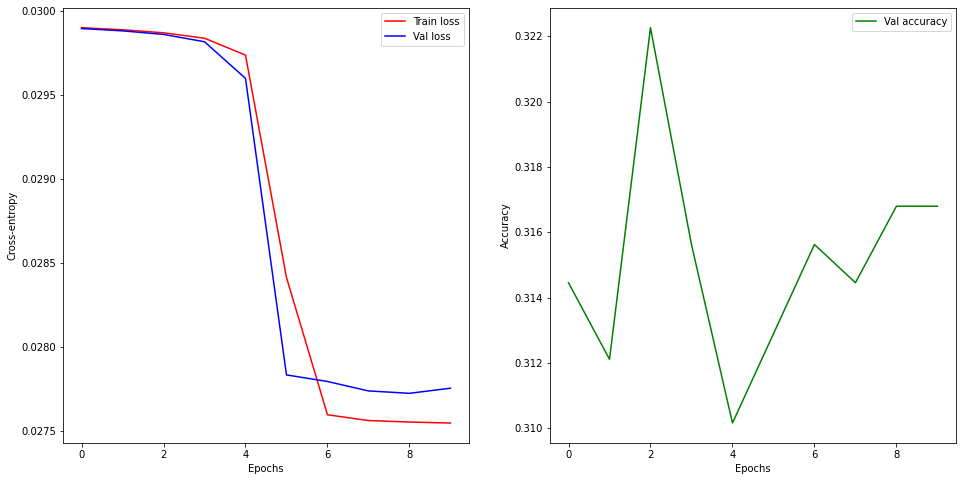

In [38]:
import matplotlib.pyplot as plt

def plot_progress(train_losses, val_losses, val_accuracies):
    fig, (left, right) = plt.subplots(1, 2, figsize=(16,8))

    left.plot(train_losses, color='red', label='Train loss')
    left.plot(val_losses, color='blue', label='Val loss')
    left.legend()
    left.set_xlabel('Epochs')
    left.set_ylabel('Cross-entropy')

    right.plot(val_accuracies, color='green', label='Val accuracy')
    right.legend()
    right.set_xlabel('Epochs')
    right.set_ylabel('Accuracy')
    fig.show()

plot_progress(train_losses, val_losses, val_accuracies)

In [ ]:
torch.save(network, 'model_vanilla_attention_swda.pkl')

## Evaluation with accuracy

In [ ]:
network = torch.load('model_vanilla_attention_swda.pkl') 
print('Vanilla attention accuracy:', evaluate(network, test_loader, device))

# Hard-guided Attention

In [ ]:
network = model.Seq2SeqModel(
    pretrained_embeddings = pretrained_embeddings,
    encoder = model.HierarchicalEncoder(
        input_size = pretrained_embeddings.shape[1],
        sequence_length = 5,
        hidden_size = 128,
        persona_level = False,
    ),
    decoder = model.HardGuidedAttentionDecoder(
        hidden_size = 128,
        sequence_length = 5,
    ),
    nb_classes = 5,
    hidden_size = 128,
)
torchinfo.summary(network)

In [ ]:
train_losses, test_losses, val_accuracies = train(
    network,
    train_loader,
    test_loader,  
    optimizer = torch.optim.SGD(network.parameters(), lr=3e-3),
    loss_fn = torch.nn.CrossEntropyLoss(),
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    n_epochs = 300
)

In [ ]:
plot_progress(train_losses, val_losses, val_accuracies)

In [ ]:
torch.save(network, 'model_hard_guided_swda.pkl')

In [ ]:
network = torch.load('model_hard_guided_swda.pkl') 
print('Vanilla attention accuracy:', evaluate(network, test_loader, device))

# Soft Guided Attention
## Training

In [ ]:
network = model.Seq2SeqModel(
    pretrained_embeddings = pretrained_embeddings,
    encoder = model.HierarchicalEncoder(
        input_size = pretrained_embeddings.shape[1],
        sequence_length = 5,
        hidden_size = 128,
        persona_level = False,
    ),
    decoder = model.SoftGuidedAttentionDecoder(
        hidden_size = 128,
        sequence_length = 5,
    ),
    nb_classes = 5,
    hidden_size = 128,
)
torchinfo.summary(network)

In [ ]:
train_losses, test_losses, val_accuracies = train(
    network,
    train_loader,
    test_loader,  
    optimizer = torch.optim.SGD(network.parameters(), lr=3e-3),
    loss_fn = torch.nn.CrossEntropyLoss(),
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    n_epochs = 300
)

In [ ]:
plot_progress(train_losses, val_losses, val_accuracies)

In [ ]:
torch.save(network, 'model_soft_guided_swda.pkl')

In [ ]:
network = torch.load('model_soft_guided_swda.pkl')
print('Vanilla attention accuracy:', evaluate(network, test_loader, device))